# Contents

- [Reiteration of Problem statement](#Reiteration-of-Problem-statement)
- [Methodology](#Methodology)
- [Preprocessing](#Preprocessing)
- [Model with Base Features](#Model-with-Base-Features)
- [Polynomial Features](#Polynomial-Features)
- [SMOTE](#SMOTE)
- [Model Evaluaton](#Model-Evaluaton)
- [Cost-Benefit Analysis of Spraying](#Cost-Benefit-Analysis-of-Spraying)
- [Conclusions](#Conclusions)

# Reiteration of Problem Statement

In view of the recent epidemic in Windy City of Chicago state affecting the state population, we aim to build a classifier model to make predictions on the possibility of West Nile Virus occurence on various locations of interest, which could be used to aid the deployment of pesticides in the fight for public health and safety. 
The model would be build using collected data related to mosquito population from the surveillance and control system setup by Deparment of Public Health. 

In addition, a cost-benefit analysis would be conducted on the cost benefits for the use of pesticides as a response in managing the epidemic. 

# Methodology

The methodology involved in the modelling process can be described as follows:

**1) Preprocessing and direct modelling**
 - Converting the data into suitable format for modelling
 - Applying baseline classifier to set baseline metric for comparison with of other models
 - Applying pearson's correlation with 3 different cutoff points for correlation (> 0.01, > 0.05 and > 0.1) to identify correlated features while selecting useful features for direct modelling. Models considered are listed in point 4
 
**2) Feature Expansion**
 - Generate polynomial and interaction features to increase the number of features involving cross terms with a degree 2 to prevent excessive feature expansion and scaling the data subsequently
 
**3) Feature Selection**
 - A) Recursive Feature Selection to select ideal features for modelling
 - B) Principal Component Analysis to reduce dimensionality of features by using principal component features generated from the data features
 
**4) Modelling, hyperparameter tuning and best model selection**

- Models considered with hyperparameters dictated by gridsearch
 - A) **Support Vector Classifier**: Effective in high dimensional spaces. Uses a subset of training points in the decision function.
 - B) **Logistic Regression**: Effective in binary classification.
 - C) **Gradient boost**: Produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. Uses gradient descent algorithm.
 - D) **Xg boost**: Similar to gradient boost, but it uses a more regularized model formalization to control over-fitting.
 - E) **Random Forest**: Constructs decision trees at training time and outputting the class that is the mode of the classes.
 - F) **Extra Trees**: Similar to Random Forest. However, the splits of the trees in the Random Forest are deterministic. It is random for extratrees.

- Subsequently finetune the parameters, and select the best model based on ROC-AUC score, precision and recall.

In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
import sklearn.metrics as metrics
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [2]:
train = pd.read_csv('../assets/train_combined.csv', parse_dates=['date'])
test = pd.read_csv('../assets/test_combined.csv', parse_dates=['date'])

## Model with Base Features

We will first try the various models with our existing set of features to compare which models perform better.

### Preprocessing

In [3]:
# Define X, y
y = train['wnvpresent']
X = train.drop(columns=['wnvpresent','date'])

# Train/test split our data.
X_train, X_holdout, y_train, y_holdout = train_test_split(X,
                                                          y,
                                                          stratify = y,
                                                          test_size = 0.30,
                                                          random_state = 42)

### Models & Parameters

We will instantiate the models with various parameters to gridsearch through.

In [4]:
# Support Vector Machine
svc = SVC(probability=True, random_state=42)

svc_params = {
    'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'clf__C': [1, 2]
}

In [5]:
# Logistic Regression
logreg = LogisticRegression(
    solver='liblinear',
    max_iter=1000, 
    random_state=42,
)

logreg_params = {
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [0.1, 1, 1.5, 2.5]
}

In [6]:
# Gradient Boost
gb = GradientBoostingClassifier(random_state=42)

gb_params = {
    'clf__learning_rate': [0.05, 0.1],
    'clf__max_depth': [2, 3]
}

In [7]:
# XGBoost
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='auc',
    objective='binary:logistic',
    random_state=42,
    n_jobs=-1
)

xgb_params = { 
    'clf__max_depth': [3, 4], #Depth of tree (higher value implies likely overfit)
    'clf__gamma' : [0.1, 0.2 , 0.3], #Min loss reduction required for further partition
    'clf__learning_rate' : [0.1, 0.2], #step size feature weight shrinkage
}

In [8]:
# Random Forest
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_params = {
    'clf__n_estimators': [100, 150, 200],
    'clf__max_depth': [4, 5, 6]
}

In [9]:
# Extra Trees
et = ExtraTreesClassifier(random_state=42, n_jobs=-1)

et_params = {
    'clf__n_estimators': [50, 75, 100],
    'clf__max_depth': [4, 5, 6]
}

In [10]:
# List of classifiers & params
classifiers = [
    (logreg, logreg_params),
    (gb, gb_params),
    (svc, svc_params),
    (xgb, xgb_params),
    (rf, rf_params),
    (et, et_params)
]

In [11]:
# Instantiate list to store results
results = []

In [12]:
# Create function to gridsearch through models and store metrics
def model(clf, clf_params):
    
    # Instantiate pipeline
    pipe = Pipeline([
        ('ss', StandardScaler()),
        ('clf', clf)
    ])
    
    # Gridsearch for best estimator
    grid = GridSearchCV(
        pipe,
        param_grid=clf_params,
        scoring='roc_auc',
        verbose=2,
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    
    print(f'Classifier: {clf}')
    print('Best Parameters:')
    print(grid.best_params_)
    
    # Scoring metrics
    scores = {'Classifier': clf}
    y_preds = grid.predict(X_holdout)
    y_pred_probas = grid.predict_proba(X_holdout)[:, 1]
    y_train_pred_probas = grid.predict_proba(X_train)[:, 1]
    scores['Train ROC-AUC Score'] = metrics.roc_auc_score(y_train, y_train_pred_probas)
    scores['Holdout ROC-AUC Score'] = metrics.roc_auc_score(y_holdout, y_pred_probas)
    scores['F1'] = metrics.f1_score(y_holdout, y_preds)
    scores['Precision'] = metrics.precision_score(y_holdout, y_preds)
    scores['Recall'] = metrics.recall_score(y_holdout, y_preds)
    scores['Accuracy'] = metrics.accuracy_score(y_holdout, y_preds)
    
    # Storing results
    results.append(scores)
    
    return pipe

In [13]:
# Run through gridsearch for every model
for (clf, clf_params) in classifiers:
    model(clf, clf_params)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.1s finished


Classifier: LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
Best Parameters:
{'clf__C': 2.5, 'clf__penalty': 'l1'}
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    1.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.2s finished


Classifier: GradientBoostingClassifier(random_state=42)
Best Parameters:
{'clf__learning_rate': 0.1, 'clf__max_depth': 2}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   31.6s finished


Classifier: SVC(probability=True, random_state=42)
Best Parameters:
{'clf__C': 2, 'clf__kernel': 'poly'}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.5s finished


[19:50:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Classifier: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, eval_metric='auc',
              gamma=None, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=None,
              max_delta_step=None, max_depth=None, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, random_state=42,
              reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
              subsample=Non

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.7s finished


Classifier: RandomForestClassifier(n_jobs=-1, random_state=42)
Best Parameters:
{'clf__max_depth': 6, 'clf__n_estimators': 200}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/home/qzq/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  45 | elapsed:    0.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.1s finished


Classifier: ExtraTreesClassifier(n_jobs=-1, random_state=42)
Best Parameters:
{'clf__max_depth': 6, 'clf__n_estimators': 100}


/home/qzq/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
# Results sorted by holdout ROC-AUC
pd.DataFrame(results).sort_values(by='Holdout ROC-AUC Score', ascending=False).reset_index(drop=True)

,Classifier,Train ROC-AUC Score,Holdout ROC-AUC Score,F1,Precision,Recall,Accuracy
0,"XGBClassifier(base_score=None, booster=None, c...",0.928438,0.870347,0.095890,0.777778,0.051095,0.948093
1,GradientBoostingClassifier(random_state=42),0.882831,0.860295,0.028571,0.666667,0.014599,0.946520
2,"RandomForestClassifier(n_jobs=-1, random_state...",0.906933,0.852818,0.000000,0.000000,0.000000,0.946127
3,"ExtraTreesClassifier(n_jobs=-1, random_state=42)",0.868666,0.841603,0.000000,0.000000,0.000000,0.946127
4,"LogisticRegression(max_iter=1000, random_state...",0.852296,0.837027,0.000000,0.000000,0.000000,0.945733
5,"SVC(probability=True, random_state=42)",0.867558,0.778700,0.014184,0.250000,0.007299,0.945340


As seen above, the best performing model is the `XGBoost` Classifier, which had a decent holdout ROC-AUC score of 0.853. Conversely, `SVC` was by far the worst performing model. This is most likely due to how ROC-AUC is computed, as while SVC may be decent at predicting actual outcomes, it is not that great at predicting probabilities due to [how predict_proba is implemented](https://mmuratarat.github.io/2019-10-12/probabilistic-output-of-svm).

Another thing we notice is that the recall scores were quite low across the board, with only `GradientBoost` surpassing getting higher than 0.1. From the high precision & accuracy scores, we can infer that this is most likely due to the class imbalance of the dataset as mentioned earlier in the EDA.

We will explore a couple of methods to try and improve the metrics:
1. Feature Expansion (Polynomial Feature Generation)
    - To try and improve target metric by adding more features to the model
2. SMOTE
    - To try and address the class imbalance issue

## Further Modelling - Polynomial Feature Generation

We will try generating polynomial features on our training data to see if we can improve the metrics of our models. PolynomialFeatures will generate new polynomial and interaction features, exponentially increasing the number of features for our model. This might uncover some important features that exist in higher dimensions or as an interaction between two separate features.

### Preprocessing

In [15]:
# Poly by power of 2.  
pf = PolynomialFeatures(degree=2, include_bias=False)  
# Fit and transform our X data using Polynomial Features.  
X_poly = pf.fit_transform(X)

# Train/test split our data.
Xp_train, Xp_holdout, y_train, y_holdout = train_test_split(X_poly,
                                                            y,
                                                            stratify=y,
                                                            test_size=0.3,
                                                            random_state=42)      

# Instantiate our StandardScaler.
ss = StandardScaler()
# Scale X_train.
Xp_train_sc = ss.fit_transform(Xp_train)
# Scale X_test.
Xp_holdout_sc = ss.transform(Xp_holdout)

In [16]:
Xp_train_sc.shape

(5932, 1274)

As seen above, this generates over a thousand features, many of which might not be meaningful to our model. We will explore a couple of methods to reduce the dimensionality or complexity of our model to achieve better performance

### PCA

1) We perform PCA to reduce the dimensionality of our models, selecting the best principal components to be used.

**Two assumptions that PCA makes:**

 -- A. **Linearity:** PCA detects and controls for linear relationships, so we assume that the data does not hold nonlinear relationships (or that we don't care about these nonlinear relationships).
    - We are using our covariance matrix to determine important "directions," which is a measure of the linear relationship between observations!
    
 -- B. **Large variances define importance:** If data is spread in a direction, that direction is important! If there is little spread in a direction, that direction is not very important.

2) GridsearchCV to find the best parameters for each model. Compare the best performing model for each feature set, then evaluate the metrics

In [17]:
# Instantiate PCA.
pca = PCA()
# Fit PCA on the training data.
pca.fit(Xp_train_sc)
# Transform PCA on the training data.
Z_train = pca.transform(Xp_train_sc)
# Don't forget to transform the test data!
Z_holdout = pca.transform(Xp_holdout_sc)

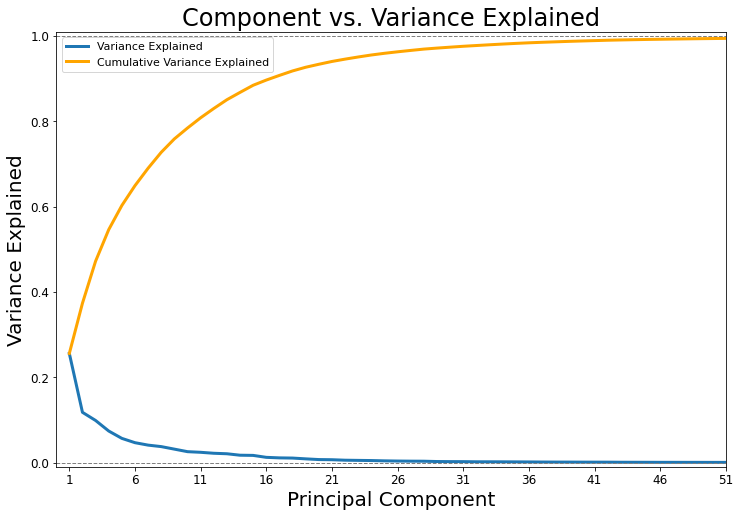

In [18]:
# Plot the variance explained (and cumulative variance explained).

# Pull the explained variance attribute.
var_exp = pca.explained_variance_ratio_
#print(f'Explained variance (first 50 components): {np.round(var_exp[:50],3)}')

# Generate the cumulative explained variance.
cum_var_exp = np.cumsum(var_exp)
#print(f'Cumulative explained variance (first 50 components): {np.round(cum_var_exp[:50],3)}')

# Set figure size.
plt.figure(figsize=(12,8))

# Plot the explained variance.
plt.plot(range(len(var_exp)), var_exp, lw=3, label = 'Variance Explained')

# Plot the cumulative explained variance.
plt.plot(range(len(var_exp)), cum_var_exp, lw=3, color = 'orange', label = 'Cumulative Variance Explained')

# Add horizontal lines at y=0 and y=1.
plt.axhline(y=0, linewidth=1, color='grey', ls='dashed')
plt.axhline(y=1, linewidth=1, color='grey', ls='dashed')

# Set the limits of the axes.
plt.xlim([-1,31])
plt.ylim([-0.01,1.01])

# Label the axes.
plt.ylabel('Variance Explained', fontsize=20)
plt.xlabel('Principal Component', fontsize=20)

# Make the tick labels bigger
plt.xticks(range(0, 51, 5), range(1, 52, 5), fontsize=12)
plt.yticks(fontsize=12)
    
# Add title and legend.
plt.title('Component vs. Variance Explained', fontsize=24)
plt.legend(fontsize=11);

Based on our graph above, we can observe that the top 30 components are able to explain the 97.6% of the variance, top40 at 98.9% and all 50 at 99.4%.  
However, we will perform GridSearch to find the best components number to fit into our model.

In [19]:
# Create DataFrame and write data in
pca_model_results = pd.DataFrame(columns=['model', 'best_params'])

# List of pipeline steps for each model
pipelist = [ 
    [('pca', PCA()),('logreg', LogisticRegression(solver='lbfgs', max_iter=5000))],
    [('pca', PCA()),('xgboost', XGBClassifier())]
]

# Name each steps to include in out model
steps_titles = ['logreg', 'xgb']

# Set the pipeline parameters
pipe_params = [
    # For logreg
    {'pca__n_components': [30,40,50],
     'logreg__C': [1,10,20]},
    # For xgb
    {'pca__n_components': [30,40,50],
    'xgboost__max_depth': [3, 4, 5, 6], #Depth of tree (higher value implies liekly overfit)
    'xgboost__gamma' : [ 0.0, 0.2 , 0.4], #Min loss reduction required for further partition
    'xgboost__learning_rate' : [0.15, 0.25, 0.35], #step size feature weight shrinkage
    'xgboost__use_label_encoder' : [False],
    'xgboost__eval_metric': ["auc"],
    "xgboost__objective" : ["binary:logistic"]}
]

In [20]:
# Loop through our GridSearch and write into our table (gscv_results)
for i in range(len(steps_titles)):     
    print(f"Step {i}")
    pipe = Pipeline(steps=pipelist[i]) 
    gs = GridSearchCV(pipe, pipe_params[i], cv=3) 
    
    # Results for each model (dict)
    model_metric = {}

    gs.fit(Z_train, y_train)
    
    # Set each value into temporary dict
    model_metric['model'] = steps_titles[i]
#     model_metric['best_params'] = gs.best_params_
#     model_metric['train_score'] = round(gs.score(Z_train, y_train), 4)
#     model_metric['test_score'] = round(gs.score(Z_holdout, y_holdout), 4)
    
    preds = gs.predict(Z_holdout)
    preds_proba = gs.predict_proba(Z_holdout)[:,1]
    train_preds_proba = gs.predict_proba(Z_train)[:,1]
    
    model_metric['Train ROC-AUC Score'] = metrics.roc_auc_score(y_train, train_preds_proba)
    model_metric['Holdout ROC-AUC Score'] = metrics.roc_auc_score(y_holdout, preds_proba)
    model_metric['F1'] = metrics.f1_score(y_holdout, preds)
    model_metric['Precision'] = metrics.precision_score(y_holdout, preds)
    model_metric['Recall'] = metrics.recall_score(y_holdout, preds)
    model_metric['Accuracy'] = metrics.accuracy_score(y_holdout, preds)
    
    model_results = pca_model_results.append(model_metric, ignore_index=True)

Step 0
Step 1
[19:50:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:50:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:50:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may no

[19:51:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:51:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:51:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate 

[19:51:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:51:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:51:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate 

[19:51:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:51:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:51:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate 

[19:52:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:52:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:52:05] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate 

[19:52:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:52:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:52:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate 

[19:52:41] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:52:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:52:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate 

[19:53:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:53:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:53:05] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate 

[19:53:26] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:53:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:53:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate 

[19:53:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:53:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:53:50] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate 

[19:54:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:54:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:54:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate 

[19:54:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:54:36] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:54:38] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate 

[19:55:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:55:05] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:55:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate 

[19:55:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:55:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:55:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate 

[19:55:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:55:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:55:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate 

[19:56:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:56:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:56:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate 

In [21]:
#pd.set_option('display.max_colwidth', None)
pca_model_results

,model,best_params


Markdown table (in case):

| Models   | Best Params                                                                                                                                                                                                            | Test ROC-AUC Score | test_score | train_score |
|----------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------|------------|-------------|
| Logistic | {'logreg__C': 1, 'pca__n_components': 30}                                                                                                                                                                              | 0.825832           | 0.9457     | 0.9459      |
| XGBoost  | {'pca__n_components': 40, 'xgboost__eval_metric': 'auc', 'xgboost__gamma': 0.4, 'xgboost__learning_rate': 0.15, 'xgboost__max_depth': 3, 'xgboost__objective': 'binary:logistic', 'xgboost__use_label_encoder': False} | 0.840012           | 0.9473     | 0.9501      |

<u>**Polynomial + PCA Summary**</u>

Firstly, we expanded the features using polynomial features with degree of 2. This created 1000+ features in our feature set. 
Then we used PCA to try to reduce the dimensionality.  
As observed above, we can explain up to 99.4% of the variation in our data with 50 components at best.

During our modelling process, we tried multiple models (Logistic reg, AdaBoost, Gradient Boost, SVM, Random Forest, Extra Trees and XGBoost.

From the model summary table, we noticed that the best 2 models were XGBoost classifier and logistic regression. They did perform well on our accuracy score and ROC-AUC score, although the recall scores were quite low. We will compare these models with others during our model evaluation later on.

The holdout ROC-AUC score that we prioritise and can be obtained from our procedure above only yielded 0.84 at best.

### Feature Selection by Correlation with Target

**Feature Selection**

We will filter the features using Pearson's correlation with 4 different cutoff points for correlation (0, 0.01, 0.05, 0.1). This will help us gradually reduce the number of features until we find a feature set that gives us the best holdout ROC-AUC score.

We will gridsearch through the same parameters for the same set of models as before, except that we will be using a different set of features

In [22]:
# Convert the polynomial expansion np.arrays to dataframe
X_poly = pd.DataFrame(X_poly, columns = pf.get_feature_names(X.columns))
Xp_train = pd.DataFrame(Xp_train, columns = pf.get_feature_names(X.columns))
Xp_holdout = pd.DataFrame(Xp_holdout, columns = pf.get_feature_names(X.columns))

In [23]:
y

0       0
1       0
2       0
3       0
4       0
       ..
8470    0
8471    0
8472    0
8473    0
8474    0
Name: wnvpresent, Length: 8475, dtype: int64

In [24]:
# Sorting by correlation to y
corr_df = X_poly.join(y).corr()[['wnvpresent']].abs().sort_values(by='wnvpresent', ascending=False)
# Instantiate result list
results_fs = []

#create a function to gridsearch all models

def model_fs(clf, clf_params, cutoff):
    
    # Feature list with correlation to y > cutoff value
    features = list(corr_df[corr_df['wnvpresent'] > cutoff].index[1:])
    # Instantiate pipeline
    pipe = Pipeline([
        ('ss', StandardScaler()),
        ('clf', clf)
    ])
    
    # Gridsearch for best estimator
    grid = GridSearchCV(
        pipe,
        param_grid=clf_params,
        scoring='roc_auc',
        verbose=2,
        n_jobs=-1
    )

    grid.fit(Xp_train[features], y_train)
    
    print(f'Classifier: {clf}, Cutoff value: {cutoff}')
    print('Best Parameters:')
    print(grid.best_params_)
    
    # Scoring metrics
    scores = {'Classifier': clf, 'Cutoff': cutoff}
    y_preds = grid.predict(Xp_holdout[features])
    y_pred_probas = grid.predict_proba(Xp_holdout[features])[:, 1]
    y_train_pred_probas = grid.predict_proba(Xp_train[features])[:, 1]
    scores['Train ROC-AUC Score'] = metrics.roc_auc_score(y_train, y_train_pred_probas)
    scores['Holdout ROC-AUC Score'] = metrics.roc_auc_score(y_holdout, y_pred_probas)
    scores['F1'] = metrics.f1_score(y_holdout, y_preds)
    scores['Precision'] = metrics.precision_score(y_holdout, y_preds)
    scores['Recall'] = metrics.recall_score(y_holdout, y_preds)
    scores['Accuracy'] = metrics.accuracy_score(y_holdout, y_preds)
    
    # Storing results
    results_fs.append(scores)
    
    return pipe

In [25]:
# Iterate function through each cutoff point
for cutoff in [0, 0.01, 0.05, 0.1]:
    for (clf, clf_params) in classifiers:
        model_fs(clf, clf_params, cutoff)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   38.9s finished


Classifier: LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'), Cutoff value: 0
Best Parameters:
{'clf__C': 1.5, 'clf__penalty': 'l1'}
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:   54.5s remaining:   13.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.1min finished


Classifier: GradientBoostingClassifier(random_state=42), Cutoff value: 0
Best Parameters:
{'clf__learning_rate': 0.1, 'clf__max_depth': 2}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.0min finished


Classifier: SVC(probability=True, random_state=42), Cutoff value: 0
Best Parameters:
{'clf__C': 5, 'clf__kernel': 'linear'}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   57.7s finished


[20:09:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Classifier: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, eval_metric='auc',
              gamma=None, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=None,
              max_delta_step=None, max_depth=None, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, random_state=42,
              reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
              subsample=Non

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.4s finished


Classifier: RandomForestClassifier(n_jobs=-1, random_state=42), Cutoff value: 0
Best Parameters:
{'clf__max_depth': 5, 'clf__n_estimators': 200}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/home/qzq/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.3s finished


Classifier: ExtraTreesClassifier(n_jobs=-1, random_state=42), Cutoff value: 0
Best Parameters:
{'clf__max_depth': 6, 'clf__n_estimators': 75}
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   34.2s finished


Classifier: LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'), Cutoff value: 0.01
Best Parameters:
{'clf__C': 2.5, 'clf__penalty': 'l1'}
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:   48.7s remaining:   12.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   59.9s finished


Classifier: GradientBoostingClassifier(random_state=42), Cutoff value: 0.01
Best Parameters:
{'clf__learning_rate': 0.1, 'clf__max_depth': 2}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.7min finished


Classifier: SVC(probability=True, random_state=42), Cutoff value: 0.01
Best Parameters:
{'clf__C': 5, 'clf__kernel': 'linear'}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   50.8s finished


[20:20:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Classifier: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, eval_metric='auc',
              gamma=None, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=None,
              max_delta_step=None, max_depth=None, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, random_state=42,
              reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
              subsample=Non

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.9s finished


Classifier: RandomForestClassifier(n_jobs=-1, random_state=42), Cutoff value: 0.01
Best Parameters:
{'clf__max_depth': 6, 'clf__n_estimators': 200}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    4.7s finished


Classifier: ExtraTreesClassifier(n_jobs=-1, random_state=42), Cutoff value: 0.01
Best Parameters:
{'clf__max_depth': 6, 'clf__n_estimators': 100}
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/home/qzq/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   21.4s finished


Classifier: LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'), Cutoff value: 0.05
Best Parameters:
{'clf__C': 2.5, 'clf__penalty': 'l2'}
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:   27.7s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   35.1s finished


Classifier: GradientBoostingClassifier(random_state=42), Cutoff value: 0.05
Best Parameters:
{'clf__learning_rate': 0.1, 'clf__max_depth': 2}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.7min finished


Classifier: SVC(probability=True, random_state=42), Cutoff value: 0.05
Best Parameters:
{'clf__C': 5, 'clf__kernel': 'linear'}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   29.0s finished


[20:28:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Classifier: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, eval_metric='auc',
              gamma=None, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=None,
              max_delta_step=None, max_depth=None, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, random_state=42,
              reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
              subsample=Non

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    7.2s finished


Classifier: RandomForestClassifier(n_jobs=-1, random_state=42), Cutoff value: 0.05
Best Parameters:
{'clf__max_depth': 6, 'clf__n_estimators': 100}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/home/qzq/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.0s finished


Classifier: ExtraTreesClassifier(n_jobs=-1, random_state=42), Cutoff value: 0.05
Best Parameters:
{'clf__max_depth': 6, 'clf__n_estimators': 100}
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/home/qzq/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  40 | elapsed:    2.5s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   15.9s finished


Classifier: LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'), Cutoff value: 0.1
Best Parameters:
{'clf__C': 2.5, 'clf__penalty': 'l1'}
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/qzq/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    9.4s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   12.0s finished


Classifier: GradientBoostingClassifier(random_state=42), Cutoff value: 0.1
Best Parameters:
{'clf__learning_rate': 0.1, 'clf__max_depth': 3}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.3min finished


Classifier: SVC(probability=True, random_state=42), Cutoff value: 0.1
Best Parameters:
{'clf__C': 5, 'clf__kernel': 'rbf'}


/home/qzq/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   10.2s finished


[20:30:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Classifier: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, eval_metric='auc',
              gamma=None, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=None,
              max_delta_step=None, max_depth=None, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, random_state=42,
              reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
              subsample=Non

/home/qzq/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    4.7s finished


Classifier: RandomForestClassifier(n_jobs=-1, random_state=42), Cutoff value: 0.1
Best Parameters:
{'clf__max_depth': 6, 'clf__n_estimators': 200}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/home/qzq/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  45 | elapsed:    1.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


Classifier: ExtraTreesClassifier(n_jobs=-1, random_state=42), Cutoff value: 0.1
Best Parameters:
{'clf__max_depth': 6, 'clf__n_estimators': 100}


/home/qzq/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
# Display results sorted by holdout ROC-AUC score
pd.DataFrame(results_fs).sort_values(by='Holdout ROC-AUC Score', ascending=False).reset_index(drop=True)

,Classifier,Cutoff,Train ROC-AUC Score,Holdout ROC-AUC Score,F1,Precision,Recall,Accuracy
0,"XGBClassifier(base_score=None, booster=None, c...",0.01,0.918562,0.857152,0.028369,0.500000,0.014599,0.946127
1,GradientBoostingClassifier(random_state=42),0.05,0.884891,0.855815,0.040541,0.272727,0.021898,0.944160
2,"XGBClassifier(base_score=None, booster=None, c...",0.00,0.942442,0.855403,0.160000,0.923077,0.087591,0.950452
3,"XGBClassifier(base_score=None, booster=None, c...",0.05,0.916794,0.855230,0.014085,0.200000,0.007299,0.944947
4,"LogisticRegression(max_iter=1000, random_state...",0.01,0.880634,0.854353,0.041379,0.375000,0.021898,0.945340
5,"LogisticRegression(max_iter=1000, random_state...",0.00,0.878991,0.854213,0.041667,0.428571,0.021898,0.945733
6,GradientBoostingClassifier(random_state=42),0.01,0.889833,0.852942,0.054054,0.363636,0.029197,0.944947
7,"RandomForestClassifier(n_jobs=-1, random_state...",0.01,0.938433,0.852716,0.000000,0.000000,0.000000,0.945733
8,GradientBoostingClassifier(random_state=42),0.00,0.891547,0.851727,0.066667,0.384615,0.036496,0.944947
9,"LogisticRegression(max_iter=1000, random_state...",0.05,0.875911,0.849347,0.013986,0.166667,0.007299,0.944554


We see that in terms of test ROC-AUC score, the best model is xgboost classifier at a correlation cutoff of 0.01 with the following best parameters:
{'clf__eta': 0.15, 'clf__gamma': 0.0, 'clf__max_depth': 3}. 

The next best model in terms of test ROC-AUC score would be gradient boosting classifier at a correlation cutoff of 0.05 with the following best parameters:
{'clf__learning_rate': 0.1, 'clf__max_depth': 2}.

Again, the models performed pretty well in terms of the holdout ROC-AUC score (except for SVC) but poorly for recall. We will compare these models later on.

## Further Modelling - SMOTE

As mentioned before, we still have low recall scores even after adding features to our model. We will see if we can improve this by resolving the class imbalance in our dataset using `SMOTE` - Synthetic Minority OverSampling Technique.

In [27]:
# Instantiate SMOTE
sm = SMOTE()

# Create synthetic data for training set
Xsm_train, ysm_train = sm.fit_resample(Xp_train, y_train)

In [28]:
# Instantiate empty list to store results
results_smote = []

In [29]:
def model_smote(clf, clf_params):
      
    # Instantiate pipeline
    pipe = Pipeline([
        ('ss', StandardScaler()),
        ('clf', clf)
    ])
    
    # Gridsearch for best estimator
    grid = GridSearchCV(
        pipe,
        param_grid=clf_params,
        scoring='roc_auc',
        verbose=2,
        n_jobs=-1
    )

    grid.fit(Xsm_train, ysm_train)
    
    print(f'Classifier: {clf}')
    print('Best Parameters:')
    print(grid.best_params_)
    
    # Scoring metrics
    scores = {'Classifier': clf}
    y_preds = grid.predict(Xp_holdout)
    y_pred_probas = grid.predict_proba(Xp_holdout)[:, 1]
    y_train_pred_probas = grid.predict_proba(Xsm_train)[:, 1]
    scores['Train ROC-AUC Score'] = metrics.roc_auc_score(ysm_train, y_train_pred_probas)
    scores['Holdout ROC-AUC Score'] = metrics.roc_auc_score(y_holdout, y_pred_probas)
    scores['F1'] = metrics.f1_score(y_holdout, y_preds)
    scores['Precision'] = metrics.precision_score(y_holdout, y_preds)
    scores['Recall'] = metrics.recall_score(y_holdout, y_preds)
    scores['Accuracy'] = metrics.accuracy_score(y_holdout, y_preds)
    
    # Storing results
    results_smote.append(scores)
    
    return pipe

In [30]:
# Gridsearch through models again with SMOTED train data
for (clf, clf_params) in classifiers:
    model_smote(clf, clf_params)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.7min finished


Classifier: LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
Best Parameters:
{'clf__C': 2.5, 'clf__penalty': 'l2'}
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:  1.4min remaining:   21.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.8min finished


Classifier: GradientBoostingClassifier(random_state=42)
Best Parameters:
{'clf__learning_rate': 0.1, 'clf__max_depth': 3}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 36.2min


KeyboardInterrupt: 

In [32]:
results_smote

[{'Classifier': LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'),
  'Train ROC-AUC Score': 0.8922371760645271,
  'Holdout ROC-AUC Score': 0.8410527816711263,
  'F1': 0.24657534246575344,
  'Precision': 0.14614343707713126,
  'Recall': 0.7883211678832117,
  'Accuracy': 0.7404640188753441},
 {'Classifier': GradientBoostingClassifier(random_state=42),
  'Train ROC-AUC Score': 0.952143361720049,
  'Holdout ROC-AUC Score': 0.8389989139074454,
  'F1': 0.2672540381791483,
  'Precision': 0.16727941176470587,
  'Recall': 0.6642335766423357,
  'Accuracy': 0.8037750688163586}]

In [33]:
# SMOTE Results, sorted by holdout ROC-AUC score
pd.DataFrame(results_smote).sort_values(by='Holdout ROC-AUC Score', ascending=False).reset_index(drop=True)

,Classifier,Train ROC-AUC Score,Holdout ROC-AUC Score,F1,Precision,Recall,Accuracy
0,"LogisticRegression(max_iter=1000, random_state...",0.892237,0.841053,0.246575,0.146143,0.788321,0.740464
1,GradientBoostingClassifier(random_state=42),0.952143,0.838999,0.267254,0.167279,0.664234,0.803775


As seen above, the `GradientBoost` model performed the best in terms of holdout ROC-AUC score. Compared to the results without SMOTE, the ROC-AUC is slightly worse. However, the models perform significantly better in terms of recall and F1-score.

## Model Evaluation

|Classifier|Cutoff|PCA_components|Train ROC-AUC Score|Test ROC-AUC Score|F1|Precision|Recall|Accuracy|
|---|---|---|---|---|---|---|---|---|
||||||||||
||||||||||
||||||||||
||||||||||

... evaluate

### Kaggle Submission

In [ ]:
# SMOTE entire training dataset
sm = SMOTE()
Xsm, ysm = sm.fit_resample(X, y)

In [ ]:
# Instantiate final model
gb_final = GradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=3,
)

In [ ]:
# Fit to SMOTED data
gb_final.fit(Xsm, ysm)

In [ ]:
# Create submission dataframe
submission = test[['id']]
submission.columns = ['Id']

In [ ]:
submission['WnvPresent'] = gb_final.predict_proba(test.drop(columns=['id', 'date']))[:, 1]

In [ ]:
submission.head()

In [ ]:
# Visualise distribution of predicted probabilities
plt.hist(submission['WnvPresent']);

In [ ]:
# Export to csv file for submission
submission.to_csv('../assets/wnv_submission.csv', index=False)

# Cost-Benefit Analysis of Spraying

...

**Effectiveness of Spraying**

Earlier during our EDA (refer plot below), we saw that during year 2011 and 2013, spraying was conducted in several areas in the city.
However, we observed that even with spraying, particularly in 2013 (where spraying was the most), the number of positive WNV clusters still increases!

Hence, spraying will not be very useful as a short-term response to combat WNV.   
Next, we can take a look if spraying has any long term effect. We will use the results predicted by our model to fill in for 2012 and 2014.

![EDA plot](../assets/images/EDA-spray-plot.png)

In [ ]:
spray = pd.read_csv('../assets/spray.csv')
spray["Date"] = pd.to_datetime(spray["Date"], format = "%Y-%m-%d")
spray.columns = [col.lower() for col in spray.columns]
spray['year'] = spray.date.dt.year
# Drop the outliers (spray but not within the area where train data is available)
spray.drop(spray.index[list(range(95))], inplace=True)

train['year'] = train.date.dt.year
test['year'] = test.date.dt.year

In [ ]:
predicted_result = pd.read_csv('../assets/kaggleSubmission.csv')
predicted_result.columns = [col.lower() for col in predicted_result.columns]
predicted_result['wnvpresent'] = predicted_result['wnvpresent'].map(lambda x: 0 if x < 0.5 else 1)

In [ ]:
update_test = test.merge(predicted_result, on='id')

In [ ]:
# Code is borrowed from: https://www.kaggle.com/users/213536/vasco/predict-west-nile-virus/west-nile-heatmap

mapdata = np.loadtxt("../assets/mapdata_copyright_openstreetmap_contributors.txt")
spray11 = spray[spray['year']==2011][['date','longitude', 'latitude']]
train11 = train[(train['year']==2011)&(train['wnvpresent']==1)][['date', 'longitude', 'latitude']]
pred12 = update_test[(update_test['year']==2012)&(update_test['wnvpresent']==1)][['date', 'longitude', 'latitude']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations = spray11[['longitude', 'latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='x')

yesno11 = train11[['longitude', 'latitude']].drop_duplicates().values
plt.scatter(yesno11[:,0], yesno11[:,1], marker='x', alpha=1, color='red', s=100)

yesno12 = pred12[['longitude', 'latitude']].drop_duplicates().values
plt.scatter(yesno12[:,0], yesno12[:,1], marker='x', alpha=1, color='yellow', s=100);

Above map shows the region (**blue**) where spraying was conducted in 2011.

**Red** crosses shows the places where WNV is positive in 2011, while the **yellow** crosses  is positive for 2012.
The crosses with **orange** body are places where WNV is positive for both 2011 AND 2012.

We can see that during 2011, the region spray only had 1 positive cluster in 2011, but had 5 positive clusters in 2012 instead.

In [ ]:
# Code is borrowed from: https://www.kaggle.com/users/213536/vasco/predict-west-nile-virus/west-nile-heatmap

mapdata = np.loadtxt("../assets/mapdata_copyright_openstreetmap_contributors.txt")
spray13 = spray[spray['year']==2013][['date','longitude', 'latitude']]
train13 = train[(train['year']==2013)&(train['wnvpresent']==1)][['date', 'longitude', 'latitude']]
pred14 = update_test[(update_test['year']==2014)&(update_test['wnvpresent']==1)][['date', 'longitude', 'latitude']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations = spray13[['longitude', 'latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='x')

yesno13 = train13[['longitude', 'latitude']].drop_duplicates().values
plt.scatter(yesno13[:,0], yesno13[:,1], marker='x', alpha=1, color='red', s=100)

yesno14 = pred14[['longitude', 'latitude']].drop_duplicates().values
plt.scatter(yesno14[:,0], yesno14[:,1], marker='x', alpha=1, color='yellow', s=100);

In 2013, there were 17 cases within the sprayed region, but the tally increased to 31 in 2014.  
Hence, spraying has no long term effect here.

# Conclusions

insights/findings from evaluation & CBA